In [18]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from imagingIO import loopMice, loadData, loadBeh, getBeh
from analysis import dffCalc, filtData, smoothData, normData
from events import getEvents
from trials import markTrials
from bouts import getBouts, getBoutDur, markBouts
from statistics import stdCalc, getBoutMeans, getStats
from plotter import plotMean, plotHeat, plotTrials

In [19]:
# Start gathering the data from FR1 exp
# Mice
mice = [(8404, 6), (8857, 3), (8864, 1)]
# Parameters
behType = 'FR1'
fs = 0.05
trials=[1,12]

In [20]:
# Get file paths
fileList = loopMice(mice, behType)

# Load the data
dataList = loadData(mice, behType)

# Load the behaviour
eventList = getBeh(mice, fileList['Behaviour'], behType)

In [ ]:
# Plot the raw data
plt.figure(figsize=(20,10), facecolor="w", dpi= 150)
for i, [mus, sess] in enumerate(mice):
    ax = plt.subplot(len(mice),1,i+1)
    dataList[mus].plot(ax=ax, legend=False, cmap=plt.cm.rainbow)
    ax.set_ylabel("dF/F (%)")

In [ ]:
# dFF and plot
dFFList = dffCalc(mice, dataList, lowest=False)

# Get the events
eventStart = getEvents(mice, eventList, 'Eat_Start', trials)
eventEnd = getEvents(mice, eventList, 'Eat_End', trials)

# Plot the dFF data
plt.figure(figsize=(20,10), facecolor="w", dpi= 150)
for i, [mus, sess] in enumerate(mice):
    ax = plt.subplot(len(mice),1,i+1)
    dFFList[mus].plot(ax=ax, legend=False, cmap=plt.cm.rainbow)
    ax.set_ylabel("dF/F (%)")
    
    # Plot the eating bouts
    for i, event in enumerate(eventStart[mus]):
        ax.fill_between([eventStart[mus].loc[i+1], eventEnd[mus].loc[i+1]], -10, 50, facecolor='gray', linewidth=0, alpha=0.3, zorder=-55)

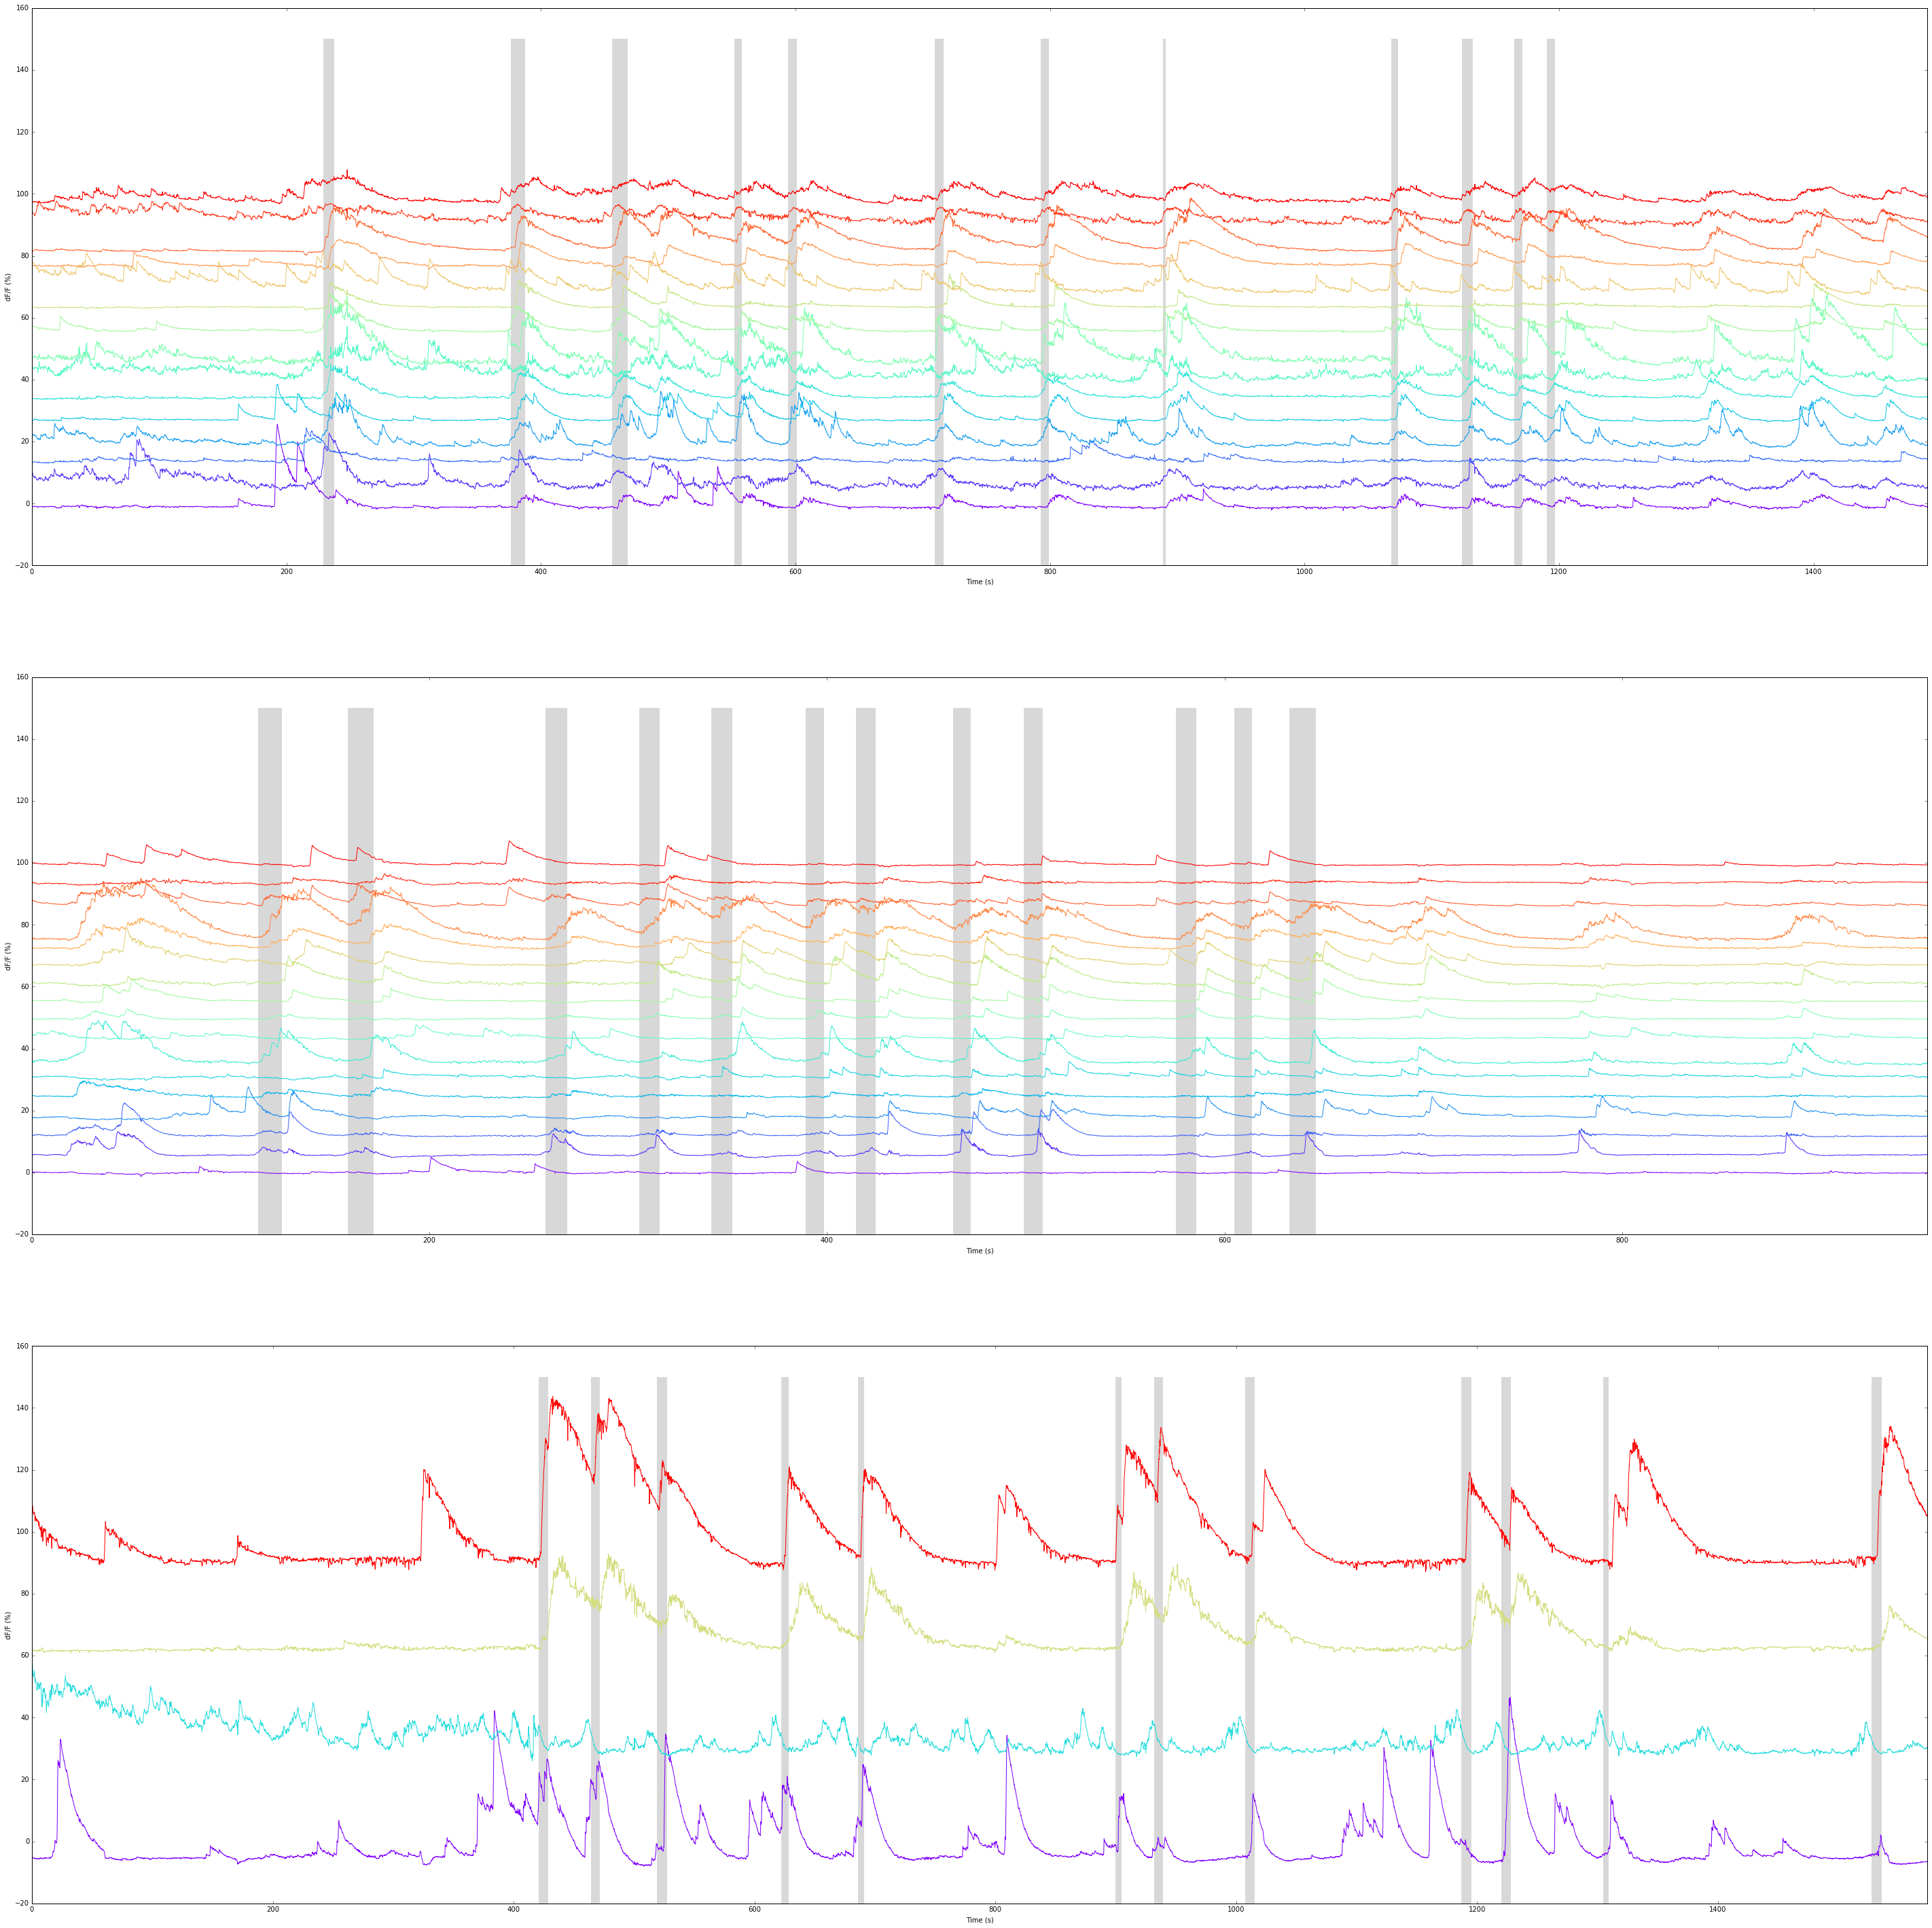

In [21]:
# dFF and plot again
filtList = filtData(mice, dffCalc(mice, dataList, lowest=False), cutoff=5.0, order=6)
dFFList = smoothData(mice, filtList, window=4)

# Normalize the data
normList = normData(mice, dFFList)

# Get the events
eventStart = getEvents(mice, eventList, 'Eat_Start', trials)
eventEnd = getEvents(mice, eventList, 'Eat_End', trials)

if 1:
    # Plot the dFF data
    n = 100
    fig = plt.figure(figsize=(50,50), facecolor="w", dpi= 150)
    for i, [mus, sess] in enumerate(mice):    
        offset = np.linspace(0, n, len(dFFList[mus].columns))
        ax = plt.subplot(len(mice),1,i+1)
        (dFFList[mus]+offset).plot(ax=ax, legend=False, cmap=plt.cm.rainbow)
        ax.set_ylabel("dF/F (%)")

        # Plot the eating bouts
        for i, event in enumerate(eventStart[mus]):
            ax.fill_between([eventStart[mus].loc[i+1], eventEnd[mus].loc[i+1]], -20, 150, facecolor='gray', linewidth=0, alpha=0.3, zorder=-55)

    #fig.savefig("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\1_all_cells_filt2_dff.pdf")

In [22]:
# Look at the event PSTHs

In [23]:
# Pick the event
eventType = 'Eat_Start'
base = -10.0
duration = 20.0

# Plot the mean of all
eventsData = markTrials(mice, dFFList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)
eventsData_norm = markTrials(mice, normList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(base,duration,fs)


3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.

3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.


In [ ]:
len(dFFList[8404]['M8404_recording_ICs1 (Fluorescence (au))']) == len(dFFList[8404]['M8404_recording_ICs1 (Fluorescence (au))'].dropna())

In [7]:
eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time')

Fluoro                      \
New_Time                                           -10.00    -9.95     -9.90    
Event Cell                                                                      
1     M8404_recording_ICs1 (Fluorescence (au))   3.528721  3.509930  3.462483   
      M8404_recording_ICs11 (Fluorescence (au)) -0.177628 -0.166779 -0.157984   
      M8404_recording_ICs16 (Fluorescence (au)) -3.187254 -3.196766 -3.234986   
      M8404_recording_ICs17 (Fluorescence (au)) -0.617666 -0.626534 -0.638728   
      M8404_recording_ICs19 (Fluorescence (au)) -0.571575 -0.571322 -0.558184   
      M8404_recording_ICs2 (Fluorescence (au))  -1.682218 -1.699310 -1.719554   
      M8404_recording_ICs21 (Fluorescence (au)) -0.000751 -0.010681 -0.025041   
      M8404_recording_ICs22 (Fluorescence (au)) -1.928870 -1.995170 -2.060453   
      M8404_recording_ICs25 (Fluorescence (au))  0.285031  0.265851  0.280054   
      M8404_recording_ICs29 (Fluorescence (au))  0.012713  0.036187  0.026217   
      M8404_recording_ICs3 (Fluorescence (au))  -0.030269 -0.007830  0.104630   
      M8404_recording_ICs30 (Fluorescence (au))  0.384849  0.339773  0.296999   
      M8404_recording_ICs31 (Fluorescence (au)) -0.484147 -0.472378 -0.400188   
      M8404_recording_ICs5 (Fluorescence (au))   0.210251  0.284769  0.332972   
      M8404_recording_ICs8 (Fluorescence (au))   1.077017  1.048243  0.989877   
      M8857_recording_ICs10 (Fluorescence (au)) -0.025755 -0.005115  0.019123   
      M8857_recording_ICs11 (Fluorescence (au))  0.028486  0.048988  0.062786   
      M8857_recording_ICs12 (Fluorescence (au))  0.062554 -0.000536 -0.065158   
      M8857_recording_ICs13 (Fluorescence (au))  0.347679  0.349593  0.341599   
      M8857_recording_ICs14 (Fluorescence (au))  0.432732  0.456707  0.458337   
      M8857_recording_ICs15 (Fluorescence (au))  0.457347  0.462622  0.458672   
      M8857_recording_ICs17 (Fluorescence (au))  0.117670  0.132544  0.121330   
      M8857_recording_ICs18 (Fluorescence (au)) -0.000938  0.002074  0.009741   
      M8857_recording_ICs19 (Fluorescence (au))  0.309415  0.307474  0.331864   
      M8857_recording_ICs2 (Fluorescence (au))   0.017219  0.037206  0.028511   
      M8857_recording_ICs3 (Fluorescence (au))  -0.159216 -0.151822 -0.142507   
      M8857_recording_ICs4 (Fluorescence (au))  -0.255130 -0.266959 -0.270484   
      M8857_recording_ICs5 (Fluorescence (au))  -3.268096 -3.288652 -3.322121   
      M8857_recording_ICs6 (Fluorescence (au))   0.043310  0.030695  0.011959   
      M8857_recording_ICs7 (Fluorescence (au))   0.235567  0.215093  0.195282   
...                                                   ...       ...       ...   
12    M8404_recording_ICs21 (Fluorescence (au))  0.151261  0.169366  0.170308   
      M8404_recording_ICs22 (Fluorescence (au)) -1.006434 -1.138947 -1.166045   
      M8404_recording_ICs25 (Fluorescence (au))  1.248336  1.253376  1.212161   
      M8404_recording_ICs29 (Fluorescence (au))  1.879678  1.716507  1.623105   
      M8404_recording_ICs3 (Fluorescence (au))   0.221066  0.241569  0.239536   
      M8404_recording_ICs30 (Fluorescence (au))  0.251466  0.270730  0.287048   
      M8404_recording_ICs31 (Fluorescence (au))  1.635866  1.684049  1.692439   
      M8404_recording_ICs5 (Fluorescence (au))   1.460104  1.415893  1.390398   
      M8404_recording_ICs8 (Fluorescence (au))   1.741093  1.719972  1.707484   
      M8857_recording_ICs10 (Fluorescence (au))  0.288691  0.306096  0.308818   
      M8857_recording_ICs11 (Fluorescence (au))  0.929691  0.890687  0.885358   
      M8857_recording_ICs12 (Fluorescence (au))  1.679219  1.676227  1.652942   
      M8857_recording_ICs13 (Fluorescence (au))  0.490266  0.538594  0.529621   
      M8857_recording_ICs14 (Fluorescence (au))  0.892845  0.903886  0.911119   
      M8857_recording_ICs15 (Fluorescence (au))  2.140564  2.155457  2.161356   
      M8857_recording_ICs17 (Fluorescence (au))  0.510705  0.725521  0.929771   
 

In [6]:
len(time), len(mean)

(600, 600)

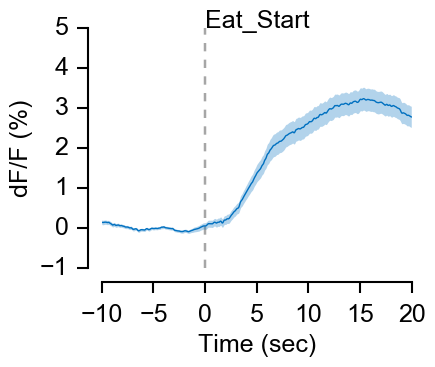

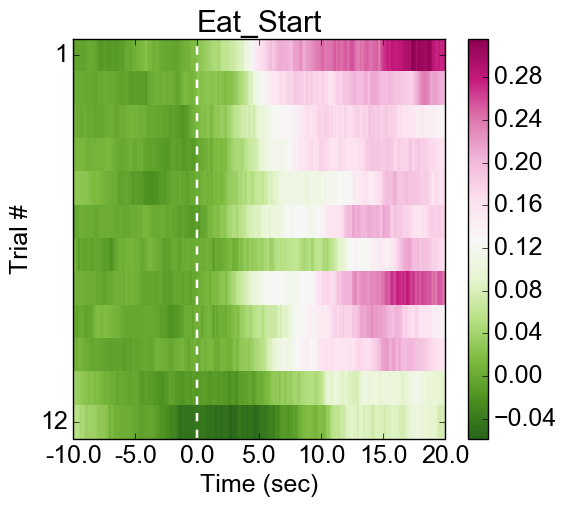

In [25]:
fig, ax = plotMean(mean, sem, time, eventType)
#fig.savefig("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\2_eat_start_all_trials_mean_10sec.svg")

fig2, ax2 = plotHeat(eventsData_norm, eventType, base, duration, trials, fs=0.05)
#fig2.savefig("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\2_eat_all_trials_heatmap_10sec.svg")

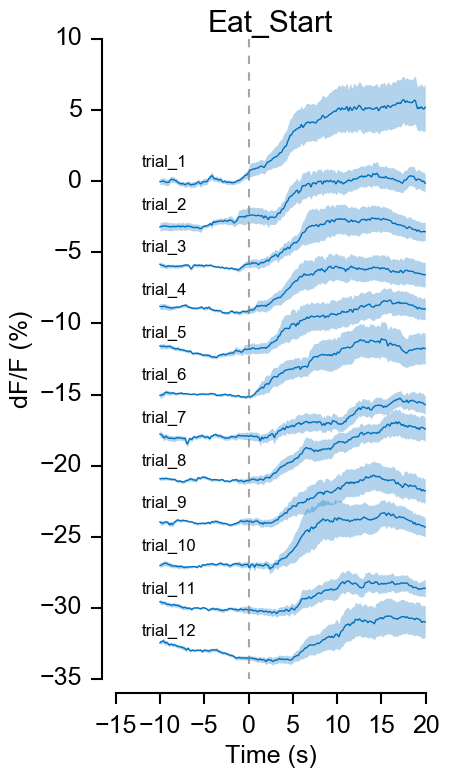

In [26]:
# Plot the trial means
trialMeans = pd.DataFrame()
for trial in range(trials[0], trials[1]+1):
    dfMeans = pd.DataFrame()
    dfMeans['Mean'] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].mean().values
    dfMeans["Sem"] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].sem().values
    dfMeans['Trial'] = trial
    trialMeans = trialMeans.append(dfMeans)

fig, ax = plotTrials(trialMeans, time=time, base=base, duration=duration, eventType=eventType, trials=trials, f=3)
#fig.savefig("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\3_eat_start_all_trials_10sec.svg")


3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.

3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.


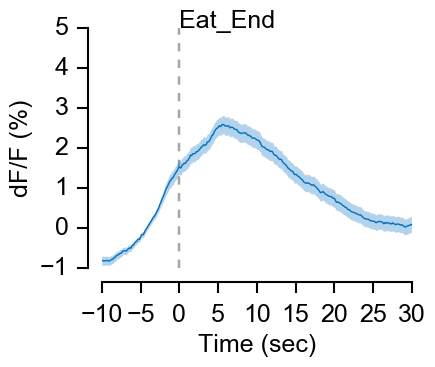

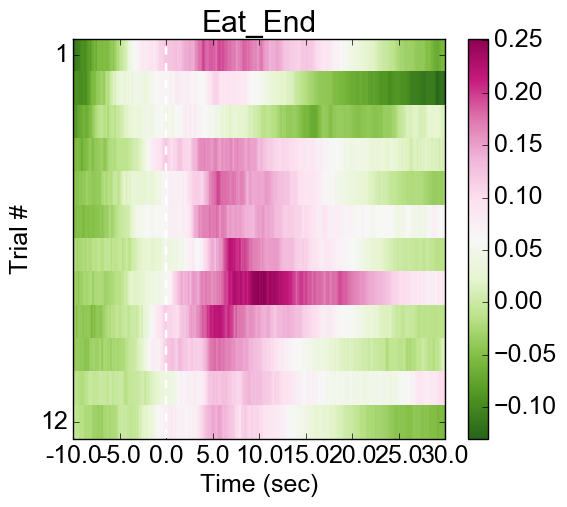

In [31]:
# Pick the event
eventType = 'Eat_End'
base = -10.0
duration = 30.0

# Plot the mean of all
eventsData = markTrials(mice, dFFList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)
eventsData_norm = markTrials(mice, normList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(base,duration,fs)

fig, ax = plotMean(mean, sem, time, eventType)
#fig.savefig("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\2_eat_end_all_trials_mean_10sec.svg")

fig2, ax2 = plotHeat(eventsData_norm, eventType, base, duration, trials, fs=0.05)
#fig2.savefig("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\2_eat_end_trials_heatmap_10sec.svg")

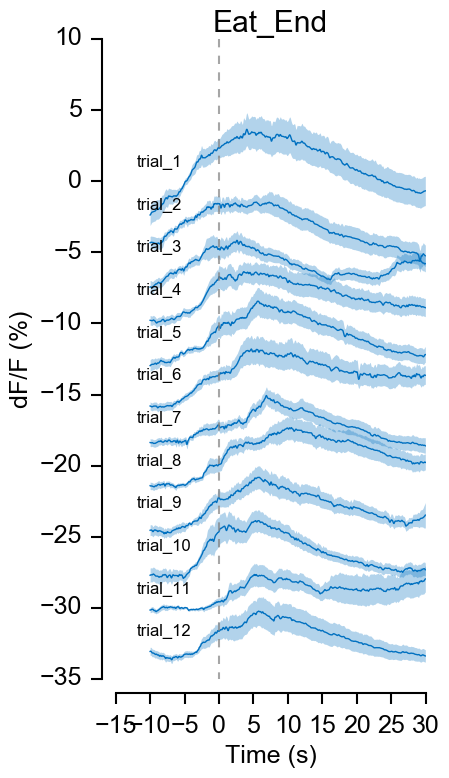

In [28]:
# Plot the trial means
trialMeans = pd.DataFrame()
for trial in range(trials[0], trials[1]+1):
    dfMeans = pd.DataFrame()
    dfMeans['Mean'] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].mean().values
    dfMeans["Sem"] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].sem().values
    dfMeans['Trial'] = trial
    trialMeans = trialMeans.append(dfMeans)

fig, ax = plotTrials(trialMeans, time=time, base=base, duration=duration, eventType=eventType, trials=trials, f=3)
#fig.savefig("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\3_eat_end_all_trials_10sec.svg")


3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.

3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.


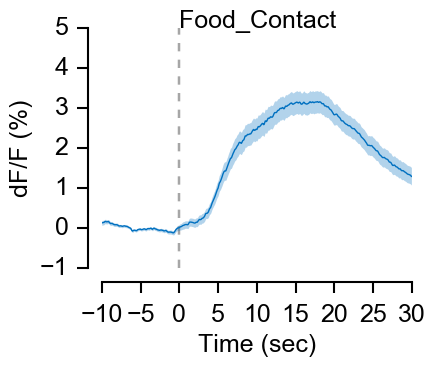

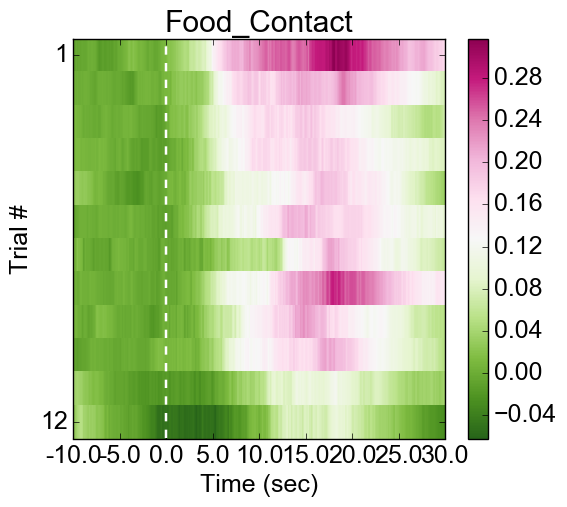

In [32]:
# Pick the event
eventType = 'Food_Contact'
base = -10.0
duration = 30.0

# Plot the mean of all
eventsData = markTrials(mice, dFFList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)
eventsData_norm = markTrials(mice, normList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(base,duration,fs)

fig, ax = plotMean(mean, sem, time, eventType)
#fig.savefig("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\2_food_contact_all_trials_mean_10sec.svg")

fig2, ax2 = plotHeat(eventsData_norm, eventType, base, duration, trials, fs=0.05)
#fig2.savefig("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\2_food_contact_trials_heatmap_10sec.svg")

In [ ]:
# Plot the trial means
trialMeans = pd.DataFrame()
for trial in range(trials[0], trials[1]+1):
    dfMeans = pd.DataFrame()
    dfMeans['Mean'] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].mean().values
    dfMeans["Sem"] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].sem().values
    dfMeans['Trial'] = trial
    trialMeans = trialMeans.append(dfMeans)

fig, ax = plotTrials(trialMeans, time=time, base=base, duration=duration, eventType=eventType, trials=trials, f=3)
fig.savefig("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\3_food_contact_all_trials_10sec.svg")


3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.

3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.


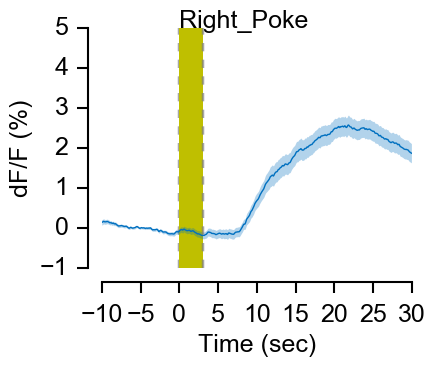

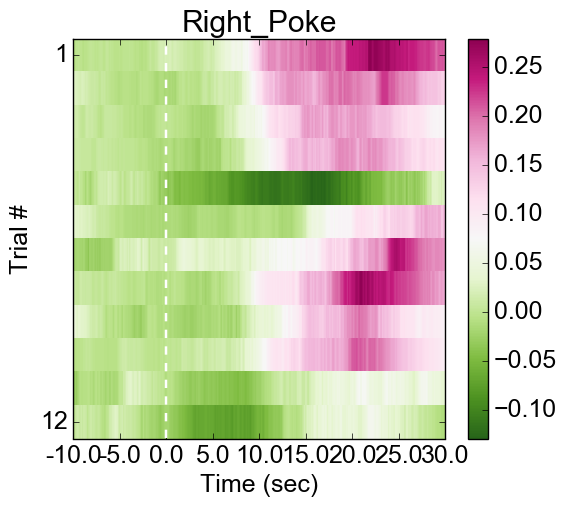

In [33]:
# Pick the event
eventType = 'Right_Poke'
base = -10.0
duration = 30.0

# Plot the mean of all
eventsData = markTrials(mice, dFFList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)
eventsData_norm = markTrials(mice, normList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(base,duration,fs)

fig, ax = plotMean(mean, sem, time, eventType)
ax.plot([3.0, 3.0],[-1, 5], 'gray', linestyle='--', linewidth=1.5*1.2, alpha=0.7)
ax.fill_between([0.0,3.0], -1, 5, facecolor='y', linewidth=0, alpha=1.0, zorder=-55)
#fig.savefig("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\2_right_poke_t_all_trials_mean_10sec.svg")

fig2, ax2 = plotHeat(eventsData_norm, eventType, base, duration, trials, fs=0.05)
#fig2.savefig("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\2_right_poke_trials_heatmap_10sec.svg")

In [ ]:
# Plot the trial means
trialMeans = pd.DataFrame()
for trial in range(trials[0], trials[1]+1):
    dfMeans = pd.DataFrame()
    dfMeans['Mean'] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].mean().values
    dfMeans["Sem"] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].sem().values
    dfMeans['Trial'] = trial
    trialMeans = trialMeans.append(dfMeans)

fig, ax = plotTrials(trialMeans, time=time, base=base, duration=duration, eventType=eventType, trials=trials, f=3)
ax.plot([3.0, 3.0],[10, -35], 'gray', linestyle='--', linewidth=1.5*1.2, alpha=0.7)
ax.fill_between([0.0,3.0], 10, -35, facecolor='y', linewidth=0, alpha=1.0, zorder=-55)
fig.savefig("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\3_right_poke_all_trials_10sec.svg")


3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.

3  mice were loaded.
Mouse number 8404  had  15  total rewards.
Mouse number 8857  had  17  total rewards.
Mouse number 8864  had  13  total rewards.


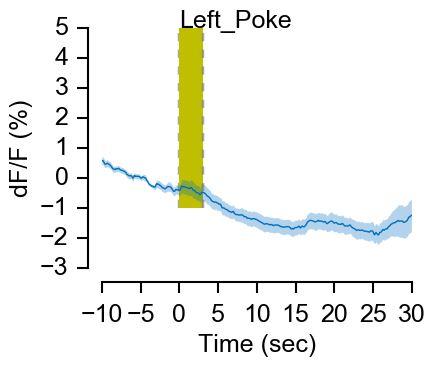

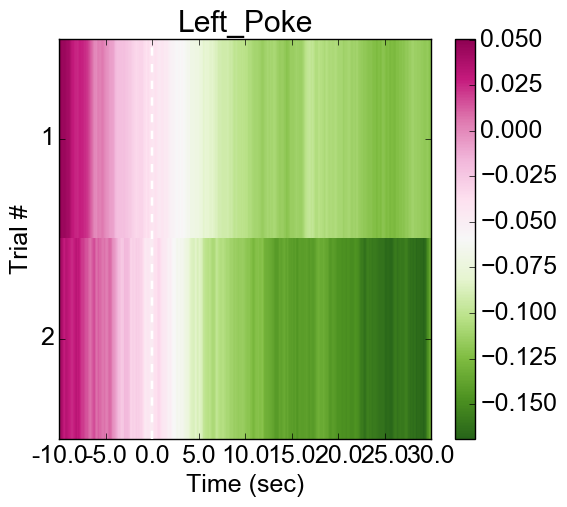

In [34]:
# Pick the event
eventType = 'Left_Poke'
base = -10.0
duration = 30.0
trials = [1,2]

# Plot the mean of all
eventsData = markTrials(mice, dFFList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)
eventsData_norm = markTrials(mice, normList, base=base, duration=duration, eventType=eventType, behType=behType, trials=trials, baselining=True)

# Calculate the mean and sem
mean=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').mean()
sem=eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').sem()
time = np.arange(base,duration,fs)

fig, ax = plotMean(mean, sem, time, eventType)
ax.plot([3.0, 3.0],[-1, 5], 'gray', linestyle='--', linewidth=1.5*1.2, alpha=0.7)
ax.fill_between([0.0,3.0], -1, 5, facecolor='y', linewidth=0, alpha=1.0, zorder=-55)
#fig.savefig("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\2_left_poke_t_all_trials_mean_10sec.svg")

fig2, ax2 = plotHeat(eventsData_norm, eventType, base, duration, trials, fs=0.05)
#fig2.savefig("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\2_left_poke_trials_heatmap_10sec.svg")

In [ ]:
# Plot the trial means
trialMeans = pd.DataFrame()
for trial in range(trials[0], trials[1]+1):
    dfMeans = pd.DataFrame()
    dfMeans['Mean'] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].mean().values
    dfMeans["Sem"] = eventsData.pivot_table(index=['Event', 'Cell'], columns='New_Time').loc[trial].sem().values
    dfMeans['Trial'] = trial
    trialMeans = trialMeans.append(dfMeans)

fig, ax = plotTrials(trialMeans, time=time, base=base, duration=duration, eventType=eventType, trials=trials, f=3)
fig.savefig("J:\\Hakan Kucukdereli\\Miniscope_Behaviour_MPIN\\scripts\\figures\\first_draft\\3_left_poke_all_trials_10sec.svg")